In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library(tidyverse)
library(readxl)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load data

The goal here is to determine the if certain environments are enriched for microcins. To do that,we need information about the assemblies so that we can figure out which environments they came from.


In [3]:
%%R
assemblySummary_SequencedGenomes <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="Sequenced-Genomes", skip=5) %>%
	separate("Sequence_Name",c("phylogroup")) %>%
	select(c("Genome_ID","phylogroup","Isolation source","Strain Category")) %>%
	rename("GEMBASE_NAME"="Genome_ID") %>%
#Remove 'Alone' and 'Soil' samples
	filter(`Strain Category` != "Alone") %>%
	filter(`Strain Category` != "Soil") %>%
#Removing three further samples that were categorized by Touchon as Alone
    filter(GEMBASE_NAME != "ESCO.0216.00100") %>%
    filter(GEMBASE_NAME != "ESCO.0216.00262") %>%
    filter(GEMBASE_NAME != "ESCO.0216.00275") %>%
	drop_na()



assemblySummary_ENAInformation <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="ENA-Information")
#metadata_aus_dataset <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="Metadata-Australian-Dataset")
best_hits <- read_csv("data/Ecoli_pangenome_best_hits.csv")


assemblySummary_SequencedGenomes %>%
	write_csv("data/supplemental/assemblySummary_SequencedGenomes.csv")

assemblySummary_SequencedGenomes

New names:
• `` -> `...8`
• `` -> `...20`
• `` -> `...28`
• `` -> `...35`
Rows: 7262 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 1,283 × 4
   GEMBASE_NAME    phylogroup `Isolation source` `Strain Category`     
   <chr>           <chr>      <chr>              <chr>                 
 1 ESCO.0216.00064 A          Host-associated    Mammal_Faecal         
 2 ESCO.0216.00065 B2         Environmental      Water                 
 3 ESCO.0216.00066 B2         Host-associated    Human_Extra-intestinal
 4 ESCO.0216.00067 B2         Host-associated    Human_E

In [4]:
%%R
best_hits_assemblyID <- best_hits %>%
	separate(cinful_id,c(NA, "ASSEMBLY_ACC_ID"), sep="/") %>%
	separate(ASSEMBLY_ACC_ID, c("ASSEMBLY_ACC"), sep = "[.]")

In [5]:
%%R 
assemblySummary_Annotated <- assemblySummary_ENAInformation %>%
	full_join(assemblySummary_SequencedGenomes) %>%
	drop_na()

assemblySummary_Annotated #%>%
#    	write_csv("data/supplemental/assemblySummary_Annotated.csv")

Joining, by = "GEMBASE_NAME"
# A tibble: 1,213 × 9
   GEMBASE_NAME    ASSEMBLY_NAME ASSEMBLY_ACC  STUDY_ID   SAMPLE_ID  CONTIG_ACC 
   <chr>           <chr>         <chr>         <chr>      <chr>      <chr>      
 1 ESCO.0216.00064 M919          GCA_902837545 PRJEB34791 ERS3882805 CADFUW0100…
 2 ESCO.0216.00065 E5795         GCA_902837575 PRJEB34791 ERS3882806 CADFUZ0100…
 3 ESCO.0216.00066 H219          GCA_902837605 PRJEB34791 ERS3882807 CADFVP0100…
 4 ESCO.0216.00069 H144          GCA_902837675 PRJEB34791 ERS3882808 CADFVR0100…
 5 ESCO.0216.00070 E7727         GCA_902837715 PRJEB34791 ERS3882809 CADFVL0100…
 6 ESCO.0216.00071 E2508         GCA_902837615 PRJEB34791 ERS3882810 CADFVH0100…
 7 ESCO.0216.00072 54_1_Ti6      GCA_902837705 PRJEB34791 ERS3882811 CADFVD0100…
 8 ESCO.0216.00073 47_4_R1       GCA_902837625 PRJEB34791 ERS3882812 CADFVE0100…
 9 ESCO.0216.00074 M714          GCA_902837745 PRJEB34791 ERS3882813 CADFVF0100…
10 ESCO.0216.00075 E7615         GCA_902837655 PRJEB34791 

In [6]:
%%R
best_hits_assemblyID_Annotated <- best_hits_assemblyID %>%
	full_join(assemblySummary_Annotated) %>%
	filter(component == "microcins.verified") %>%
	select(ASSEMBLY_ACC, phylogroup, sseqid, verified, `Strain Category`)

best_hits_assemblyID_Annotated #%>%
#	write_csv("data/supplemental/best_hits_assemblyID_Annotated.csv")

Joining, by = "ASSEMBLY_ACC"
# A tibble: 406 × 5
   ASSEMBLY_ACC  phylogroup sseqid                    verified `Strain Category`
   <chr>         <chr>      <chr>                     <lgl>    <chr>            
 1 GCA_902849325 F          E492_sp_Q9Z4N4_MCEA_KLEPN FALSE    Human_Extra-inte…
 2 GCA_902845405 D          L_tr_Q841V4_Q841V4_ECOLX  FALSE    Water            
 3 GCA_902845405 D          V_sp_P22522_CEAV_ECOLX    FALSE    Water            
 4 GCA_902842805 E          V_sp_P22522_CEAV_ECOLX    TRUE     Poultry_Meat     
 5 GCA_902843155 B1         V_sp_P22522_CEAV_ECOLX    TRUE     Bird_Faecal      
 6 GCA_902842285 B1         V_sp_P22522_CEAV_ECOLX    TRUE     Bird_Faecal      
 7 GCA_902841095 C          V_sp_P22522_CEAV_ECOLX    TRUE     Human_Faecal     
 8 GCA_902848205 A          V_sp_P22522_CEAV_ECOLX    TRUE     Bird_Faecal      
 9 GCA_902846965 B2         V_sp_P22522_CEAV_ECOLX    TRUE     Poultry_Meat     
10 GCA_902845305 B1         V_sp_P22522_CEAV_ECOLX    TRUE  

In [7]:
%%R

hits_phylogroup_by_category <- table(best_hits_assemblyID_Annotated$phylogroup, best_hits_assemblyID_Annotated$`Strain Category`)

table(best_hits_assemblyID_Annotated$phylogroup, best_hits_assemblyID_Annotated$`Strain Category`)

sum(table(best_hits_assemblyID_Annotated$phylogroup, best_hits_assemblyID_Annotated$`Strain Category`))

[1] 404


In [8]:
%%R

chisq.test(hits_phylogroup_by_category)


	Pearson's Chi-squared test

data:  hits_phylogroup_by_category
X-squared = 184.97, df = 42, p-value < 2.2e-16



In [9]:
%%R

all_phylogroup_by_category <- table(assemblySummary_Annotated$phylogroup, assemblySummary_Annotated$`Strain Category`)

table(assemblySummary_Annotated$phylogroup, assemblySummary_Annotated$`Strain Category`)

      
       Bird_Faecal Human_Extra-intestinal Human_Faecal Human_Intestinal
  A             51                     19           35               20
  B1            46                      1            0               28
  B2            31                     65           22               73
  C              1                      5            4                1
  D             29                      0            0               44
  E              8                      0            0                1
  F             17                     12            7                5
  H299           2                      2            4                0
      
       Mammal_Faecal Poultry_Meat Water
  A               21           89    56
  B1              27           48   121
  B2              35           37    38
  C                0            4     1
  D               27           43    31
  E                4           28    17
  F                3           17     9
  H299            

In [10]:
%%R

chisq.test(all_phylogroup_by_category)


	Pearson's Chi-squared test

data:  all_phylogroup_by_category
X-squared = 407.59, df = 42, p-value < 2.2e-16



In [11]:
%%R

chisq.test(x=hits_phylogroup_by_category, y=all_phylogroup_by_category)


	Pearson's Chi-squared test

data:  hits_phylogroup_by_category
X-squared = 184.97, df = 42, p-value < 2.2e-16



In [12]:
%%R

#Frequency of microcin per assembly
microcinAssemblyProportion <- length(best_hits_assemblyID_Annotated$ASSEMBLY_ACC)/length(assemblySummary_Annotated$ASSEMBLY_ACC)
microcinAssemblyProportion

#length(best_hits_assemblyID_Annotated$ASSEMBLY_ACC)
#length(assemblySummary_Annotated$ASSEMBLY_ACC)

[1] 0.3347073


In [13]:
%%R
strain_category_assemblies <- assemblySummary_Annotated %>%
	count(`Strain Category`, name="total_assemblies")
strain_category_assemblies

# A tibble: 7 × 2
  `Strain Category`      total_assemblies
  <chr>                             <int>
1 Bird_Faecal                         185
2 Human_Extra-intestinal              104
3 Human_Faecal                         72
4 Human_Intestinal                    172
5 Mammal_Faecal                       117
6 Poultry_Meat                        283
7 Water                               280


In [26]:
%%R -w 1500

microcin_strain_category <- best_hits_assemblyID_Annotated %>%
	count(`Strain Category`, name = "microcin") %>%
	full_join(strain_category_assemblies) %>%
	mutate(relative_microcin = microcin / total_assemblies) %>%
	mutate(odds = relative_microcin/(microcinAssemblyProportion)) %>%
	mutate(LOE = log10(odds)) %>%
	drop_na()

#microcin_strain_category <- microcin_strain_category %>%
#	mutate(assembly_freq = total_assemblies#/sum(total_assemblies)

microcin_strain_category


Joining, by = "Strain Category"
# A tibble: 7 × 6
  `Strain Category`     microcin total_assemblies relative_microc…  odds     LOE
  <chr>                    <int>            <int>            <dbl> <dbl>   <dbl>
1 Bird_Faecal                 50              185            0.270 0.807 -0.0929
2 Human_Extra-intestin…       52              104            0.5   1.49   0.174 
3 Human_Faecal                21               72            0.292 0.871 -0.0598
4 Human_Intestinal            64              172            0.372 1.11   0.0460
5 Mammal_Faecal               47              117            0.402 1.20   0.0792
6 Poultry_Meat               122              283            0.431 1.29   0.110 
7 Water                       48              280            0.171 0.512 -0.291 


In [15]:
%%R
#Chi square present in paper before figure 5

microcin_strain_category_chisq <- chisq.test(microcin_strain_category$total_assemblies)
microcin_strain_category_chisq


	Chi-squared test for given probabilities

data:  microcin_strain_category$total_assemblies
X-squared = 241.17, df = 6, p-value < 2.2e-16



In [16]:
%%R

freqs = microcin_strain_category$total_assemblies/sum(microcin_strain_category$total_assemblies)

microcin_strain_category_freq_chisq <- chisq.test(x = microcin_strain_category$microcin, p=freqs)

microcin_strain_category_freq_chisq


#chisq.test(microcin_strain_category$total_assemblies-microcin_strain_category$microcin, microcin_strain_category$microcin)

#microcin_strain_category$total_assemblies-microcin_strain_category$microcin


	Chi-squared test for given probabilities

data:  microcin_strain_category$microcin
X-squared = 43.834, df = 6, p-value = 7.973e-08



In [17]:
%%R
microcin_strain_category %>%
	write_csv("data/supplemental/Touchon_categories_microcins.csv")

In [18]:
%%R

library(tidyverse)
library(broom)

getwd()
setwd('/home/aaron/Documents/UT_Austin/wilke_lab/microcins_enterobacterales/notebooks')

#touchon <- read.csv("Touchon_categories_microcins.csv", header = TRUE)
touchon <- read.csv("data/supplemental/Touchon_categories_microcins_edit.csv", header = TRUE)


mydata <- read.csv("data/supplemental/Touchon_categories_microcins_edit.csv", header = TRUE)
#mydata <- tibble(
#  group = letters[1:5],
#  samples = c(10, 20, 50, 100, 5),
#  hits = c(9, 5, 2, 3, 4)
#)

mydata <- mydata[,]

samples_tot <- sum(mydata$samples)
hits_tot <- sum(mydata$hits)

fisher_results <- mydata %>%
  mutate(
    fit = map2(
      samples, hits,
      ~fisher.test(cbind(c(samples_tot, .x), c(hits_tot, .y)))
    ),
    glance_out = map(fit, glance)
  ) %>%
  select(group, glance_out) %>%
  unnest(cols = glance_out) %>%
  mutate(
    # adjust for multiple testing
    p.adj = p.adjust(p.value, method = "fdr"),
    # sort
    group = fct_reorder(group, estimate),
    # significance label
    label = case_when(
      p.adj < 0.001 ~ "*",
#      p.adj < 0.01 ~ "**",
#      p.adj < 0.05 ~ "*",
      TRUE ~ ""
    ),
    # for label justification
    hjust = ifelse(estimate < 1, 1.1, -0.1)
  ) %>%
  rename(
    odds_ratio = estimate
  )
fisher_results


# A tibble: 7 × 10
  group   odds_ratio p.value conf.low conf.high method alternative   p.adj label
  <fct>        <dbl>   <dbl>    <dbl>     <dbl> <chr>  <chr>         <dbl> <chr>
1 Bird_F…      0.812 2.25e-1    0.570     1.14  Fishe… two.sided   3.93e-1 ""   
2 Human_…      1.50  2.71e-2    1.03      2.16  Fishe… two.sided   8.57e-2 ""   
3 Human_…      0.876 7.11e-1    0.505     1.46  Fishe… two.sided   7.11e-1 ""   
4 Human_…      1.12  4.72e-1    0.807     1.53  Fishe… two.sided   5.50e-1 ""   
5 Mammal…      1.21  3.01e-1    0.825     1.74  Fishe… two.sided   4.21e-1 ""   
6 Poultr…      1.29  3.67e-2    1.01      1.66  Fishe… two.sided   8.57e-2 ""   
7 Water        0.515 3.03e-5    0.363     0.717 Fishe… two.sided   2.12e-4 "*"  
# … with 1 more variable: hjust <dbl>


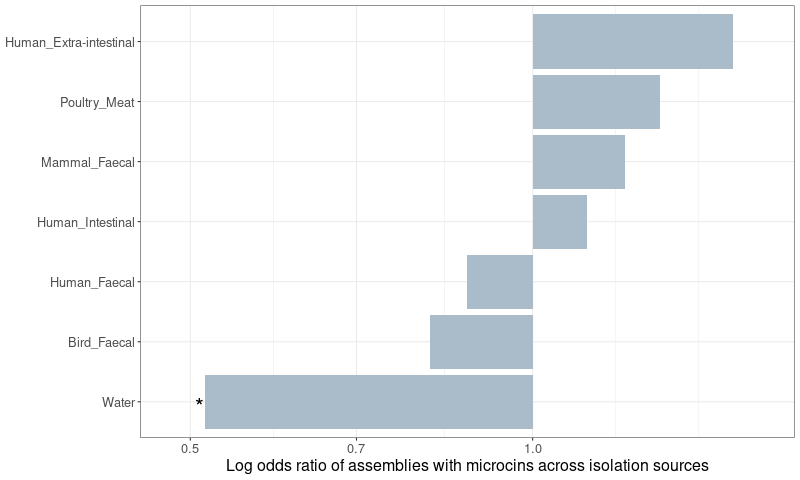

In [19]:
%%R -w 800

ggplot(fisher_results, aes(odds_ratio, group)) +
    geom_col() +
    geom_text(aes(label = label, hjust = hjust), size = 8, vjust = 0.8) +
    scale_x_log10(limits = c(0.48, 1.6)) +
    ylab(NULL) + 
    xlab("Log odds of assembly containing microcin")+
    geom_bar(stat = "identity", fill = "#aabbcaff") +
	ylab(NULL) + 
	xlab("Log odds ratio of assemblies with microcins across isolation sources") +
	theme_bw() +
	theme(text = element_text(size = 16))

#ggsave("plots/AF/05_ecoli_microcin_environment_v2.svg")